# Mesh Neural Cellular Automata

This notebook allows you to train a MeshNCA model with image textures. You can either use a
* Single RGB Texture Image
* Multiple textures for physically-based rendering (albedo, normal, roughness, ...)

Note that the colab version is slower.
For faster training please refer to the github repository and follow the running instructions.



# 1 - Install Dependencies and Clone the Repo

 Currently the code needs cuda 12 and PyTorch 2.1.1 to run, due to the dependencies of the NVIDIA Kaolin library. This stage might take a few minutes to complete.

*   Make sure your Hardware accelerator is set to GPU: Runtime > Change runtime type > Hardware Accelerator
*   Make sure to **restart the runtime** after this stage is done




In [1]:
%cd /content/
!git clone https://github.com/IVRL/MeshNCA.git

## Installing the requirements
!pip install torch==2.1.1 torchvision==0.16.1 --index-url https://download.pytorch.org/whl/cu121
!pip install kaolin -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.1.1_cu121.html
!pip install torch_geometric==2.5.3
!pip install moviepy
!pip install pyyam
!pip install gdown
!pip install wandb

/content
Cloning into 'MeshNCA'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 118 (delta 51), reused 102 (delta 35), pack-reused 0
Receiving objects: 100% (118/118), 15.70 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 547.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
  Attempting uninstall: torchvision
    F

# 2 - Download the meshes and texture images

The data will be downloaded to the `data` directory and has three parts:

* The mesh dataset consisting of 48 meshes with valence close to 6 and uniformly distributed vertices. The meshes are stored at `data/meshes/`.
* 72 Physically-based-rendering (PBR) textures, each containing 5 textures (albedo, normal, roughness, height, and
  ambient occlusion) All textures have a resolution of 1024x1024. The PBR Textres are stored at `data/pbr_textures/`.
* 45 RGB textures adopted from [DyNCA](https://dynca.github.io/). The RGB Textures are stored at `data/textures/`.

You can also upload your own textures and meshes into the corresponding folders.



In [2]:
%cd MeshNCA
!python3 download_data.py

/content/MeshNCA
Downloading...
From (original): https://drive.google.com/uc?id=1TsA3fyr1OU_1C4Rk5rtBp-Zzr_54Bofn
From (redirected): https://drive.google.com/uc?id=1TsA3fyr1OU_1C4Rk5rtBp-Zzr_54Bofn&confirm=t&uuid=9bb7d2a6-46c7-4885-8ef5-a99ebdc66661
To: /content/MeshNCA/data/pbr_textures.zip
100% 137M/137M [00:06<00:00, 21.5MB/s]
Unzipping the PBR Texture dataset
Downloading...
From (original): https://drive.google.com/uc?id=136uliL3tcQinNXg3LXcJB4_Qf-HXg2A3
From (redirected): https://drive.google.com/uc?id=136uliL3tcQinNXg3LXcJB4_Qf-HXg2A3&confirm=t&uuid=822bad81-f6ff-416e-9bf8-4b45d4b740fe
To: /content/MeshNCA/data/meshes.zip
100% 41.0M/41.0M [00:02<00:00, 17.8MB/s]
Unzipping the Mesh dataset
Downloading...
From: https://drive.google.com/uc?id=1Wv7vvPGMf3V4tuv2OL12jewBNTsRUP8S
To: /content/MeshNCA/data/textures.zip
100% 1.45M/1.45M [00:00<00:00, 13.9MB/s]
Unzipping the Texture dataset


# 3 - Import the modules


In [3]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

from utils.mesh import Mesh
from utils.camera import PerspectiveCamera
from utils.render import Renderer
from models.meshnca import MeshNCA
from losses.loss import Loss
from utils.video import VideoWriter


from IPython.display import Markdown, clear_output

!nvidia-smi -L

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


GPU 0: Tesla T4 (UUID: GPU-092aead5-35aa-bb4e-0c7e-ee64b5a8de33)


# 4 - Visualize the texture and meshes
  ### Visualize the texture


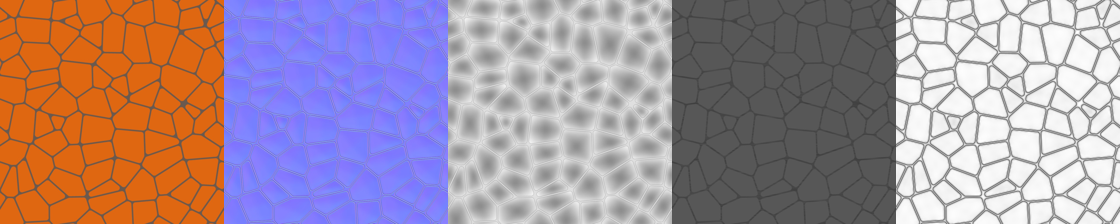

In [18]:
#@title Visualize textures {vertical-output: true}
texture_type = "PBR" #@param ["RGB", "PBR"]

if texture_type == "RGB":
  rgb_texture = "bubbly_0101" #@param ["chequered_0121", "polka_dotted_0121"]  {allow-input: true}
  assert f"{rgb_texture}.jpg" in os.listdir("data/textures/")
  target_images_path = {"rgb": f"data/textures/{rgb_texture}.jpg"}
  display(Image.open(target_images_path["rgb"]).resize((224, 224)))
else:
  pbr_texture = "Abstract_008" #@param ["Wall_Shells_001", "Lava_005"]  {allow-input: true}
  assert f"{pbr_texture}" in os.listdir("data/pbr_textures/")
  target_images_path = {
      "albedo": f"data/pbr_textures/{pbr_texture}/albedo.jpg",
      "normal": f"data/pbr_textures/{pbr_texture}/normal.jpg",
      "height": f"data/pbr_textures/{pbr_texture}/height.jpg",
      "roughness": f"data/pbr_textures/{pbr_texture}/roughness.jpg",
      "ambient_occlusion": f"data/pbr_textures/{pbr_texture}/ambient_occlusion.jpg",
      }

  images = [Image.open(target_images_path[k]).resize((224, 224)) for k in target_images_path]
  display(Image.fromarray(np.hstack(images)))


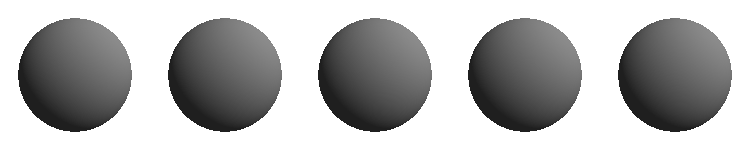

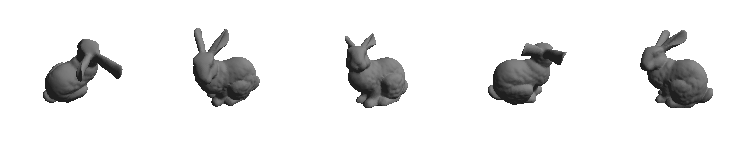

In [19]:
#@title Visualize the train and test meshes {vertical-output: true}
with torch.no_grad():

  #@markdown **Icosphere mesh Config**
  subdivision_freq = 64 #@param {"type": "integer"}
  icosphere = Mesh.load_icosphere(subdivision_freq)

  #@markdown **Test mesh Config**
  obj_name = "bunny" #@param ["mug", "armor", "bunny", "cat", "mobius"]  {allow-input: true}
  assert obj_name in os.listdir("data/meshes/")

  obj_path = f"data/meshes/{obj_name}/{obj_name}.obj"
  test_mesh = Mesh.load_from_obj(obj_path, subdivision_iter=1)

  #@markdown **Camera Config**
  num_views = 5 #@param {"type": "integer"}
  assert num_views >= 1
  camera = PerspectiveCamera.generate_random_view_cameras(num_views, distance=2.5)

  #@markdown **Renderer Config**
  ambient_light = 0.25 #@param {"type": "number"}
  directional_light = 1.0 #@param {"type": "number"}
  background_color = 1.0 #@param {"type": "number"}

  renderer = Renderer(height=150, width=150,
                          ambient_light=ambient_light,
                          directional_light=directional_light,
                          background_color=background_color)

  icosphere_vertex_colors = 0.5 * torch.ones(1, icosphere.Nv, 3) # [batch_size, num_vertices, num_features]
  test_mesh_vertex_colors = 0.5 * torch.ones(1, test_mesh.Nv, 3) # [batch_size, num_vertices, num_features]

  rendered_image = renderer.render(icosphere, camera, icosphere_vertex_colors) # [batch_size, num_views, height, width, num_features]
  display(renderer.to_pil(rendered_image))
  # print(icosphere)

  rendered_image = renderer.render(test_mesh, camera, test_mesh_vertex_colors) # [batch_size, num_views, height, width, num_features]
  display(renderer.to_pil(rendered_image))
  # print(test_mesh)


# 5 - Training Configuration


In [20]:
if texture_type == "RGB":
  num_channels = {"rgb": 3} # Number of channels in each target image
  # Corresponding channels of MeshNCA cell state for each target image
  target_channels =  {"rgb": [0, 3]}
else:
  num_channels = {
      "albedo": 3,
      "height": 1,
      "normal": 3,
      "roughness": 1,
      "ambient_occlusion": 1,
      } # Number of channels in each target image

  # Corresponding channels of MeshNCA cell state for each target image
  target_channels = {
    "albedo": [ 0, 3 ], # channels 0, 1, 2
    "normal": [ 3, 6 ], # channels 3, 4, 5
    "height": [ 6, 7 ], # channel 6
    "roughness": [ 7, 8 ], # channel 7
    "ambient_occlusion": [ 8, 9 ] # channel 8
  }

### These values are different from the experimental setup of the main paper.
### The render resolution and num_views are decreased to make the colab version faster.
train_renderer = Renderer(height=256, width=256,
                          ambient_light=1.0, directional_light=0.0,
                          background_color=0.0)
camera_distance = 2.05

meshnca = MeshNCA(channels=16, fc_dim=128,
                  sh_order=1, aggregation='sum',
                  target_channels=target_channels)

optimizer = torch.optim.Adam(meshnca.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000, 2000], gamma=0.3)

with torch.no_grad():
  pool = meshnca.seed(pool_size=256, num_vertices=icosphere.Nv)
  loss_fn = Loss(appearance_loss_weight=2.0, overflow_loss_weight=10000.0,
                 appearance_loss_kwargs={
                     "image_size": (224, 224),
                     "target_images_path": target_images_path,
                     "num_channels": num_channels,

                 })

num_views = 3
step_range = [16, 32]
inject_seed_interval = 16
batch_size = 1
epochs = 4000
render_channels = meshnca.get_render_channels()

# 6 - Train Loop


  0%|          | 0/4000 [00:00<?, ?it/s]

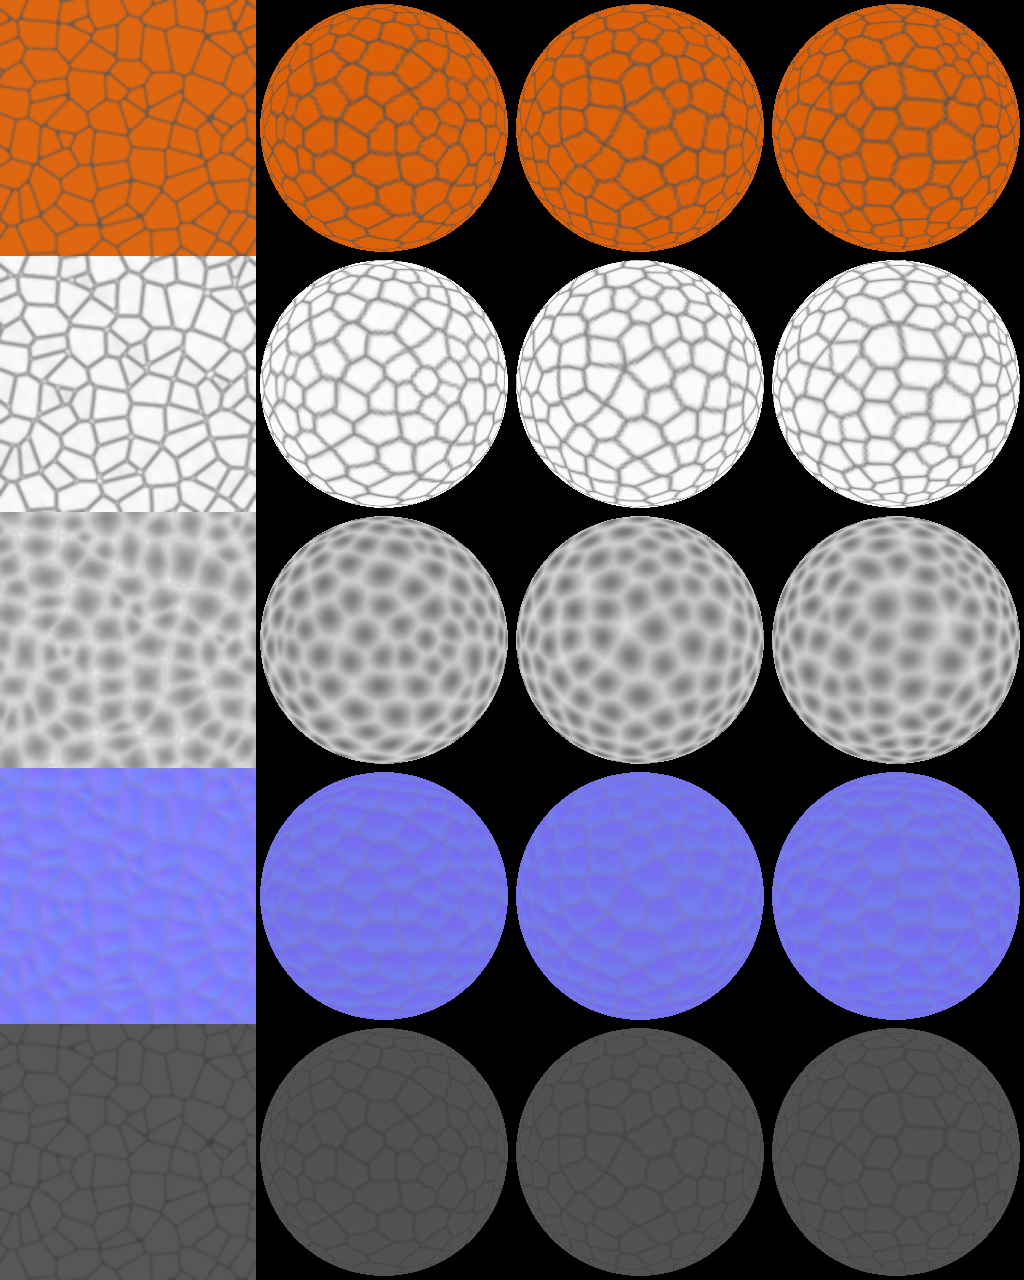


    epoch: 3975
    lr: 8.999999999999999e-05
    albedo loss: 5.368394374847412\
ambient_occlusion loss: 6.93910026550293\
height loss: 6.715053558349609\
normal loss: 7.648944854736328\
roughness loss: 3.7645530700683594

100%|██████████| 4000/4000 [56:17<00:00,  1.18it/s]


In [21]:
# @title  { vertical-output: true }
for epoch in tqdm(range(epochs)):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), batch_size, replace=False)
    x = pool[batch_idx]
    if epoch % inject_seed_interval == 0:
      x[:1] = meshnca.seed(1, icosphere.Nv)

  # MeshNCA forward iterations
  step_n = np.random.randint(step_range[0], step_range[1])
  for _ in range(step_n):
    x = meshnca(x, icosphere)

  # Render the resulting cell states.
  x_render = x[..., render_channels] + 0.5
  camera = PerspectiveCamera.generate_random_view_cameras(num_views=num_views,
                                                          distance=camera_distance)

  # rendered_image: [batch_size, num_views, height, width, num_features]
  rendered_image = train_renderer.render(icosphere, camera, x_render)

  # rendered_image: [batch_size * num_views, num_features, height, width]
  rendered_image = torch.flatten(rendered_image, start_dim=0, end_dim=1).permute(0, 3, 1, 2)


  # Pass the rendered image to the appearance loss function
  input_dict = {
      'rendered_images': rendered_image,
      'nca_state': x,
      }
  return_summary = (epoch + 0) % 25 == 0
  loss, loss_log, summary = loss_fn(input_dict, return_summary=return_summary)

  with torch.no_grad():
    loss.backward()
    for p in meshnca.parameters():
      p.grad /= (p.grad.norm() + 1e-8)  # Normalize gradients

    optimizer.step()
    optimizer.zero_grad()
    lr_scheduler.step()
    pool[batch_idx] = x  # Return the updated cell states back to the pool

  if return_summary:
    summary_image = summary['appearance-images']
    display(summary_image, display_id="batch")
    loss_log_md = [f"{target} loss: {loss_log['appearance-' + target]}"
                   for target in sorted(target_channels)]
    loss_log_md = "\\\n".join(loss_log_md)
    display(Markdown(f'''
    epoch: {epoch}
    lr: {lr_scheduler.get_last_lr()[0]}
    {loss_log_md}'''), display_id='stats')


# 7 - Test the trained model

In [26]:
#@title Generate video {vertical-output: true}

if texture_type == "RGB":
  vis_channels = range(*target_channels["rgb"])
else:
  vis_channels = range(*target_channels["albedo"])


with VideoWriter(autoplay=True) as vid, torch.no_grad():
  camera = PerspectiveCamera(elevation=[10.0], azimuth=[0.0], distance=[2.5])
  renderer = Renderer(height=256, width=256, ambient_light=0.25,
                      directional_light=1.0, background_color=1.0)

  x_icosphere = meshnca.seed(pool_size=1, num_vertices=icosphere.Nv)
  x_test_mesh = meshnca.seed(pool_size=1, num_vertices=test_mesh.Nv)

  for i in tqdm(range(360)):
    camera.rotateY(angle=1)
    step_n = 1
    for _ in range(step_n):
      x_icosphere = meshnca(x_icosphere, icosphere)
      x_test_mesh = meshnca(x_test_mesh, test_mesh)

    icosphere_img = renderer.render(icosphere,  camera,
                                    x_icosphere[..., vis_channels] + 0.5)
    icosphere_img = renderer.to_pil(icosphere_img)

    test_mesh_img = renderer.render(test_mesh,  camera,
                                    x_test_mesh[..., vis_channels] + 0.5)
    test_mesh_img = renderer.to_pil(test_mesh_img)

    render_img = np.vstack([icosphere_img, test_mesh_img])
    vid.add(render_img)

100%|██████████| 360/360 [00:47<00:00,  7.57it/s]
